# Kernel Density Estimation & Validation

In [2]:
import os
from PIL import Image
import numpy as np

img = Image.open("testimg.jpg")
X = np.asarray(img)
X = X / (2**8 - 1)
X = X.reshape(-1)
np.random.shuffle(X)

In [3]:
X_1 = X + np.random.normal(0, 0.05, X.shape)
X_2 = X + np.random.normal(0, 0.1, X.shape)

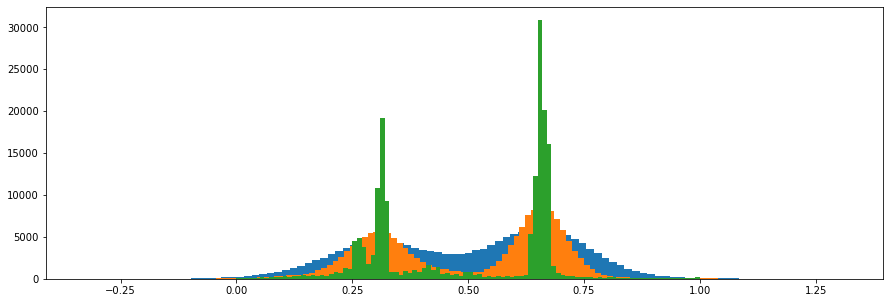

In [4]:
import matplotlib.pyplot as plt

data_sets = np.array([X, X_1, X_2][::-1])
num_hist = len(data_sets)
bins = 100
fig, ax = plt.subplots(figsize=(15, 5))
    
for i in np.arange(num_hist):
    ax.hist(data_sets[i], bins)

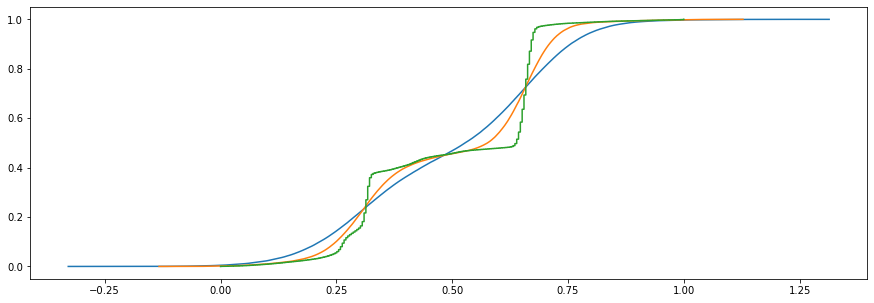

In [5]:
fig, ax = plt.subplots(figsize=(15,5))

for X in data_sets:
    x = np.sort(X)
    y = np.arange(len(X))/float(len(X))
    ax.plot(x, y)

In [6]:
def split_into_training_and_validation(X, training_size=100, test_size=5000):
    X = X.copy()
    np.random.shuffle(X)
    X_train = X[:training_size]
    X_test = X[training_size:training_size+training_size]
    return X_train, X_test

In [7]:
def top_hat_kernel(u):
    if (np.abs(u) < 0.5): return 1
    return 0

In [8]:
def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-u**2 / 2)

In [32]:
def kernel_density_estimation(x, X, kernel, h):
    p = X.shape[0]
    return (1/h) * (1/p) * sum([kernel((x - x_i) / h) for x_i in X])

In [33]:
from functools import partial
def train_kernel_density_estimation(X, kernel, h):
    return partial(kernel_density_estimation, X=X, kernel=kernel, h=h)

In [34]:
kernel_density_estimation(0.5, X, gaussian_kernel, 2)

ValueError: not enough values to unpack (expected 2, got 1)

In [12]:
kde = train_kernel_density_estimation(X, gaussian_kernel, 2)
kde(0.5)

0.19860302033287508

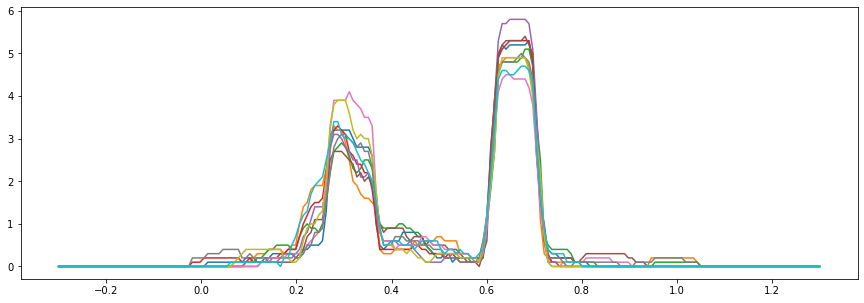

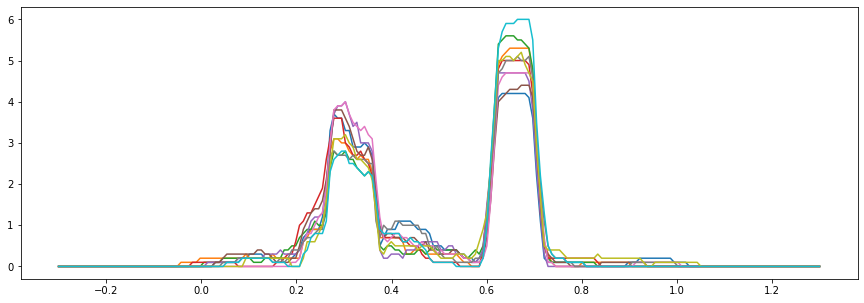

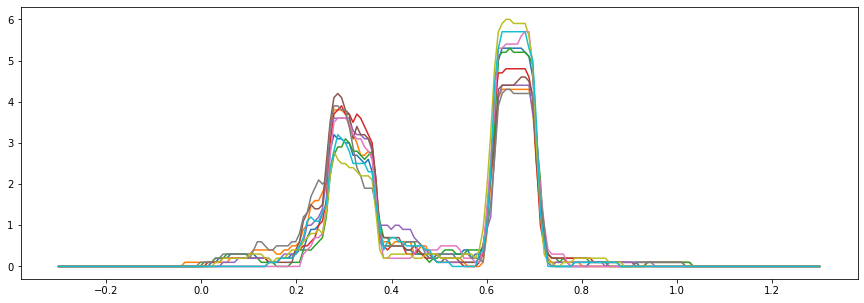

In [13]:
for h in [0.05, 0.15, 0.3]:
    fig, ax = plt.subplots(figsize=(15, 5))
    for i in np.arange(10):
        X_train, X_test = split_into_training_and_validation(X)
        x = np.linspace(-0.3, 1.3, 200)
        y = [kernel_density_estimation(x_i, X_train, top_hat_kernel, 0.1) for x_i in x]
        ax.plot(x, y)

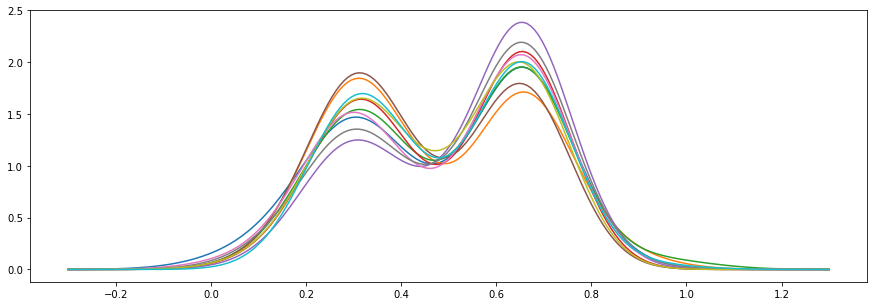

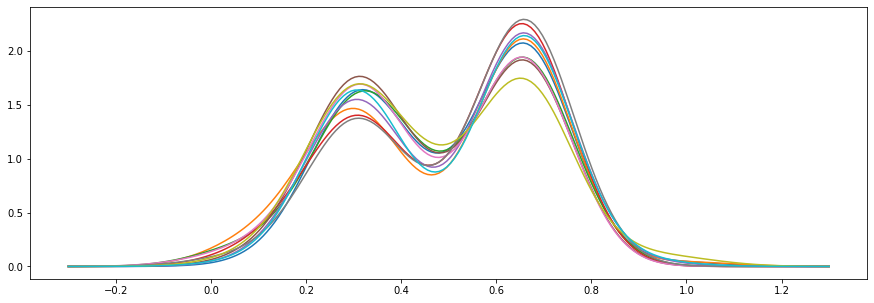

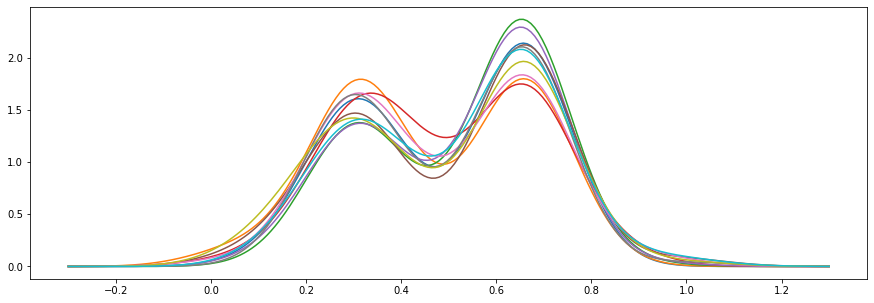

In [14]:
for h in [0.05, 0.15, 0.3]:
    fig, ax = plt.subplots(figsize=(15, 5))
    for i in np.arange(10):
        X_train, X_test = split_into_training_and_validation(X)
        x = np.linspace(-0.3, 1.3, 200)
        y = [kernel_density_estimation(x_i, X_train, gaussian_kernel, 0.1) for x_i in x]
        ax.plot(x, y)

In [15]:
def NLL(P, X_test):
    p_test = X_test.shape[0]
    return sum([-np.log(P(x_i)) for x_i in X_test]) / p_test

<ipython-input-15-fb8e3712688c>:3: RuntimeWarning: divide by zero encountered in log
  return sum([-np.log(P(x_i)) for x_i in X_test]) / p_test
<ipython-input-15-fb8e3712688c>:3: RuntimeWarning: divide by zero encountered in log
  return sum([-np.log(P(x_i)) for x_i in X_test]) / p_test
<ipython-input-15-fb8e3712688c>:3: RuntimeWarning: divide by zero encountered in log
  return sum([-np.log(P(x_i)) for x_i in X_test]) / p_test


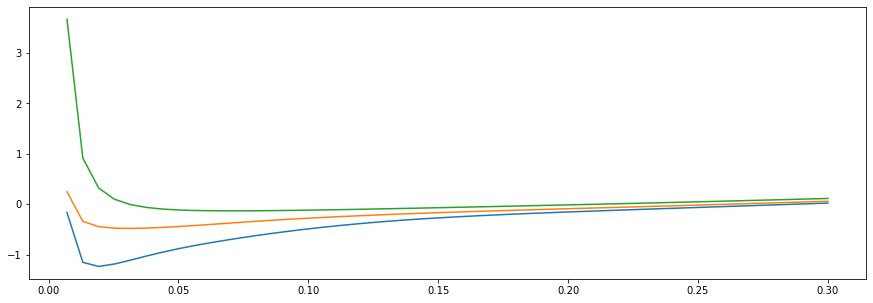

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
for X in [X, X_1, X_2]:    
    hs = np.linspace(0.001, 0.3, 50)
    X_train, X_test = split_into_training_and_validation(X)

    results = []
    for h in hs:
        kde = train_kernel_density_estimation(X_train, gaussian_kernel, h)
        result = NLL(kde, X_test)
        results.append(result)
    ax.plot(hs, results)

## sklearn

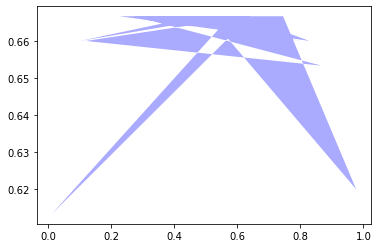

In [17]:
from sklearn.neighbors import KernelDensity

X_train, X_test = split_into_training_and_validation(X)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

fig, ax = plt.subplots()
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X_train)
log_dens = kde.score_samples(X_test)
ax.fill(X_test[:, 0], np.exp(log_dens), fc='#AAAAFF')

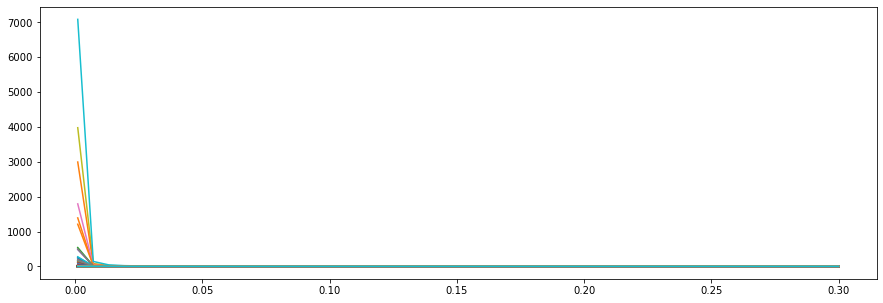

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
for X in [X, X_1, X_2]:    
    hs = np.linspace(0.001, 0.3, 50)
    X_train, X_test = split_into_training_and_validation(X)
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)

    results = []
    for h in hs:
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train)
        result = -kde.score_samples(X_test)
        results.append(result)
    ax.plot(hs, results)

In [ ]:
import timeit


X_train, X_test = split_into_training_and_validation(X)
X_test = X

In [23]:
print("Self impl...")
start = timeit.default_timer()

kde1 = train_kernel_density_estimation(X_train, gaussian_kernel, h)
result1 = np.array([kde1(x_i) for x_i in X_test])

stop = timeit.default_timer()
print('Time self: ', stop - start)

Self impl...
Time self:  189.56224418000784


In [30]:
print("sklearn impl...")
start = timeit.default_timer()

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
kde2 = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train)

result2 = np.array([np.exp(kde2.score_samples([x_i])) for x_i in X_test]).reshape(-1, 1)

stop = timeit.default_timer()
print('Time sklearn: ', stop - start)

sklearn impl...
Time sklearn:  32.574399383040145


(-1, 1)

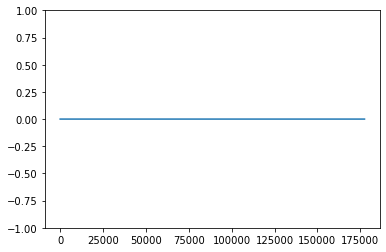

In [31]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(X_test)), result2 - result1)
ax.set_ylim(-1, 1)